In [15]:
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd

In [16]:
# read in the data into a pandas dataframe
df = pd.read_csv('Credit_N400_p9.csv')
df.head(3)

,Income,Limit,Rating,Cards,Age,Education,Gender,Student,Married,Balance
0,14.891,3606,283,2,34,11,Male,No,Yes,333
1,106.025,6645,483,3,82,15,Female,Yes,Yes,903
2,104.593,7075,514,4,71,11,Male,No,No,580


In [17]:
# recode the gender, student, and married preds 
df['Gender'].replace(to_replace = dict(Female = 0, Male = 1), inplace=True)
df['Student'].replace(to_replace = dict(No = 0, Yes = 1), inplace=True)
df['Married'].replace(to_replace = dict(No = 0, Yes = 1), inplace=True)
df.head(3)

,Income,Limit,Rating,Cards,Age,Education,Gender,Student,Married,Balance
0,14.891,3606,283,2,34,11,1,0,1,333
1,106.025,6645,483,3,82,15,0,1,1,903
2,104.593,7075,514,4,71,11,1,0,0,580


In [18]:
class ElasticNetCV:
    def __init__(self, preds, responses, lambdas, alphas, nfolds = 5, n_iters = 1000, verbose = False):
        '''
        A class that implements elastic net regression via batch coordinate descent with
        cross validation to identify the optimal tuning parameters lambda and alpha.

        Args:
            preds (np.ndarray): A N x M array where N is the number of samples and M is the 
                number of predictors or features.
            responses (np.ndarray): A N-dimensional vector of responses corresponding to 
                preds.
            lambdas (list): The different values of lambda to try.
            alphas (list): The different values of alpha to try. 
            nfolds (int): The number of cross validation folds to use for each lambda given.
                Default is 5.
            n_iters (int > 0): The number of updates to the coefficient vector before stopping. 
            verbose (bool): True for verbosity, False for quiet. 
        '''

        self.x, self.y = self._shuffle_data(preds, responses)
        self.lambdas = lambdas 
        self.alphas = alphas
        self.nfolds = nfolds 
        self.n_iters = n_iters
        self.verbose = verbose
        self._initialize()


    def _initialize(self):
        '''
        This function initializes certain values needed for training and checks that certain
        arguments have appropriate values. 
        '''

        # get number of samples and number of features
        self.n_samples = self.x.shape[0]
        self.n_preds = self.x.shape[1]
    
        # matrix to store the cross validation results 
        self.cv_vals = np.zeros([self.nfolds, len(self.lambdas), len(self.alphas)])

        # determine the number of validation samples and their inds based on nfolds 
        self.n_val_samples = self.n_samples // self.nfolds 
        self.val_inds = list(range(0, self.n_samples, self.n_val_samples))
        
        if self.verbose:
            print('[INFO] Using {} training and {} validation samples for each CV fold.'.format(
                self.n_samples - self.n_val_samples, self.n_val_samples)
            )

        # create a tensor to store the Betas 
        self.B_trained = np.zeros([self.nfolds, len(self.lambdas), len(self.alphas), self.n_preds])

        # check that all arguments are within the appropriate range of values
        # assert(all([lambda_val >= 0 for lambda_val in self.lambdas])), \
        #     'lambdas must not contain any negative values.'
        # assert(all([(alpha_val >= 0 and alpha_val <= 1) for alpha_val in self.alphas])), \
        #     'alpha values must be in [0, 1].'
        # assert(self.x.shape[0] == self.y.shape[0]), \
        #     "number of responses doesn't equal number of rows in preds."
        # assert(self.n_iters > 0), \
        #     'n_iters should be > 0.'
        # assert(type(self.verbose) == bool), \
        #     'verbose should be True or False.'

    def _standardize(self, x, mean_vec, std_vec):
        '''
        Standardizes the columns of the design matrix (i.e. makes each column zero-centered 
        with a standard deviation of 1).
        
        Args:
            x (np.ndarray): The N x M design matrix with columns to be standardized.
            mean_vec (np.ndarray): The M-dimentional vector representing the means of the columns of x.
            std_vec (np.ndarray): The M-dimensional vector representing the stds of the columns of x.

        Returns:
            x_standardized (np.ndarray): The N x M design matrix, where the columns now have mean 0 and std 1.
        '''

        return (x - mean_vec) / std_vec 

    def _center_responses(self, y, mean):
        '''
        Centers a vector of responses around the mean by subtracting the given mean from every element in y. 

        Args: 
            y (np.ndarray): The N-dimensional vector of responses. 
            mean (np.ndarray): A float to subtract from the responses in y.

        Returns:
            y_centered (np.ndarray): The N-dimensional vector of responses with mean 0. 
        '''

        return y - mean

    def _shuffle_data(self, preds, responses):
        '''
        Shuffles the rows of the design matrix and the responses. 

        Args:
            preds (np.ndarray): The N x M dimensional design matrix with N samples and M predictors.
            responses (np.ndarray): The N-dimensional response vector corresponding to preds. 

        Returns:
            preds_shuffled (np.ndarray): The N x M dimensional design matrix with permuted rows. 
            responses_shuffled (np.ndarray): The N-dimensional response vector with permuted values matching 
                preds_shuffled. 
        '''

        data = np.concatenate((preds, responses[:, None]), 1)
        np.random.shuffle(data)
        return data[:, :-1], data[:, -1]

    def _initialize_B(self):
        '''
        Initializes the coefficient vector B for each new model with values from U(-1, 1). 

        Args: 
            None

        Returns:
            B (np.ndarray): An M dimensional vector of randomly initialized coefficients.
        '''

        return np.random.uniform(low = -1, high = 1, size = (self.n_preds, 1))

    def predict(self, x):
        '''
        A function to compute predicted responses given predictors. Must be called after fit().

        Args:
            x (np.ndarray): An N x M design matrix to compute predicted responses from.

        Returns:
            y_hat (np.ndarray): An N-dimensional vector of predicted responses for x. 
        '''

        assert(self.mean_vec is not None and self.std_vec is not None), \
            'Model must be trained before predicting.'

        x = self._standardize(x, self.mean_vec, self.std_vec)
        return np.matmul(x, self.B)

    def _get_folds(self, val_ind):
        '''
        Gets the appropriate validation and training sets given the CV iteration.

        Args:
            val_ind (int): The index of the validation set for the current CV iteration.

        Returns:
            x_train (np.ndarray): The training set design matrix.
            x_val (np.ndarray): The validation set design matrix.
            y_train (np.ndarray): The vector of training responses.
            y_val (np.ndarray): The vector of validation responses. 
        '''

        x_val = self.x[val_ind:val_ind + self.n_val_samples]
        x_train = np.delete(self.x, np.arange(val_ind, val_ind + self.n_val_samples), axis = 0)
        y_val = self.y[val_ind:val_ind + self.n_val_samples]
        y_train = np.delete(self.y, np.arange(val_ind, val_ind + self.n_val_samples), axis = 0)
        return x_train, x_val, y_train, y_val

    def _update(self, x, y, B, ss_cols, lambda_, alpha):
        '''
        Performs a single iteration of coordinate descent to update the coefficient vector.

        Args:
            x (np.ndarray): The N x M training design matrix. 
            y (np.ndarray): The N x 1 vector of responses corresponding to x.
            B (np.ndarray): The M x 1 vector of the current estimate of the coefficients.
            b_k (np.ndarray): The M x 1 vector representing the sum of squares of each column in x.
            lambda_ (float): The tuning parameter lambda. 
            alpha (float): The tradeoff parameter between ridge and lasso.

        Returns:
            B_updated (np.ndarray): The M x 1 vector of updated coefficients. 
        '''
        
        for k in range(self.n_preds):
            # get rss without the effect of coefficient k
            rss_k = y - np.matmul(x, B) + (x[:, k] * B[k])[:, None]
            
            # a_k is part of the derivative of the rss term in the loss function
            a_k = np.matmul(x[:, k].transpose(), rss_k)[0]
            
            # update B_k
            B_k = np.absolute(a_k) - lambda_ * (1 - alpha) / 2
            B_k = B_k if B_k >= 0 else 0
            B[k, 0] = np.sign(a_k) * B_k / (ss_cols[k] + lambda_ * alpha)
        
        return B

    def score(self, x, y, B):
        '''
        Scores a given model given data and desired responses. 

        Args:
            x (np.ndarray): The N x M design matrix.
            y (np.ndarray): The N x 1 vector of responses. 
            B (np.ndarray): The M x 1 vector of coefficients.

        Returns:
            MSE (float): The MSE between y and xB. 
        '''

        y_hat = np.matmul(x, B)
        mse = np.mean((y - y_hat) ** 2)
        return mse
    
    def _compute_ss_cols(self, x):
        '''
        Computes the sum of squares for each column needed in the update.
        Only need to do this once per fold at the beginning. 
        
        Args:
            x (np.ndarray): The N x M design matrix of the current fold. 
            
        Returns:
            ss_cols (np.ndarray): The M-dim vector representing the sum
                of squares of the cols of x.
        '''
        return np.sum(x ** 2, 0)
    
    def _find_best_tuning_params(self):
        '''
        Finds the value of lambda and alpha with minimum corresponding CV score and
        saves them as class attributes. 
        '''
        cv_mean = np.mean(self.cv_vals, 0)
        best_lambda_ind, best_alpha_ind = np.where(cv_mean == np.amin(cv_mean))
        self.best_lambda = self.lambdas[best_lambda_ind[0]]
        self.best_alpha = self.alphas[best_alpha_ind[0]]

    def fit(self):
        '''
        Implements the cross validation and retrains the model with the optimal lambda 
        and alpha on the entire dataset.
        '''

        for i_lambda, lambda_ in enumerate(self.lambdas): # loop through lambdas
            for i_alpha, alpha in enumerate(self.alphas): # loop through alphas
                for i_fold, val_ind in zip(range(self.nfolds), self.val_inds): # loop through folds
                    # get the folds
                    x_train, x_val, y_train, y_val = self._get_folds(val_ind)

                    # standardize x and center y
                    mean_vec, std_vec = np.mean(x_train, 0), np.std(x_train, 0)
                    mean_response = np.mean(y_train)
                    x_train = self._standardize(x_train, mean_vec, std_vec)
                    x_val = self._standardize(x_val, mean_vec, std_vec)
                    y_train = self._center_responses(y_train, mean_response)[:, None]
                    y_val = self._center_responses(y_val, mean_response)[:, None]
                    
                    # compute b_k given this fold -- don't need to compute every update
                    ss_cols = self._compute_ss_cols(x_train)

                    # initialize Beta for this lambda and fold
                    B = self._initialize_B()

                    for iter in range(self.n_iters):
                        B = self._update(x_train, y_train, B, ss_cols, lambda_, alpha)
                        
                    # score this model 
                    score = self.score(x_val, y_val, B)

                    # store the score with the tuning param combinations
                    self.cv_vals[i_fold, i_lambda, i_alpha] = score

                    # store the coefficient vector
                    self.B_trained[i_fold, i_lambda, i_alpha] = B[:, 0]
                    
                # if verbose flag, then print out the mean CV MSE for the combo of lambda and alpha
                if self.verbose:
                    print('lambda:{}; alpha:{}; CV MSE:{}'.format(
                        lambda_, alpha, np.mean(self.cv_vals[:, i_lambda, i_alpha]))
                    )


        ############# Retrain on entire dataset with optimal lambda and alpha #############
                    
        # find the best lambda and alpha
        self._find_best_tuning_params()
        
        # standardize features of x and center responses 
        self.mean_vec, self.std_vec = np.mean(self.x, 0), np.std(self.x, 0)
        x = self._standardize(self.x, self.mean_vec, self.std_vec)
        y = self._center_responses(self.y, np.mean(self.y))[:, None]
        
        # compute the sum of squares for each feature on the entire dataset
        ss_cols = self._compute_ss_cols(x)
        
        # initialize coefficients
        self.B = self._initialize_B()
        
        # perform updates 
        for iter in range(self.n_iters):
            self.B = self._update(x, y, self.B, ss_cols, self.best_lambda, self.best_alpha)

In [19]:
# separate the predictors from the response
X = df.to_numpy()[:, :-1]
Y = df.to_numpy()[:, -1]
print(X.shape, Y.shape)

(400, 9) (400,)


In [20]:
# instantiate the model 
elastic_net = ElasticNetCV(
    preds = X,
    responses = Y,
    lambdas = 10 ** np.arange(-2., 7.),
    alphas = [0, 0.2, 0.4, 0.6, 0.8, 1.0],
    n_iters = 1000,
    verbose = True
)

[INFO] Using 320 training and 80 validation samples for each CV fold.


In [21]:
# fit the model
elastic_net.fit()

lambda:0.01; alpha:0; CV MSE:9916.929963729172
lambda:0.01; alpha:0.2; CV MSE:9916.973667657272
lambda:0.01; alpha:0.4; CV MSE:9917.00817794856
lambda:0.01; alpha:0.6; CV MSE:9917.051005330708
lambda:0.01; alpha:0.8; CV MSE:9917.097118360556
lambda:0.01; alpha:1.0; CV MSE:9917.122732891232
lambda:0.1; alpha:0; CV MSE:9916.935152822189
lambda:0.1; alpha:0.2; CV MSE:9917.354788581291
lambda:0.1; alpha:0.4; CV MSE:9917.908374259332
lambda:0.1; alpha:0.6; CV MSE:9918.531724759172
lambda:0.1; alpha:0.8; CV MSE:9919.239097552416
lambda:0.1; alpha:1.0; CV MSE:9920.006066192615
lambda:1.0; alpha:0; CV MSE:9916.899769105026
lambda:1.0; alpha:0.2; CV MSE:9924.400782117224
lambda:1.0; alpha:0.4; CV MSE:9934.125526216263
lambda:1.0; alpha:0.6; CV MSE:9943.58842087195
lambda:1.0; alpha:0.8; CV MSE:9952.528953933504
lambda:1.0; alpha:1.0; CV MSE:9961.079205893464
lambda:10.0; alpha:0; CV MSE:9916.599613617062
lambda:10.0; alpha:0.2; CV MSE:10003.515567096978
lambda:10.0; alpha:0.4; CV MSE:10112.1307

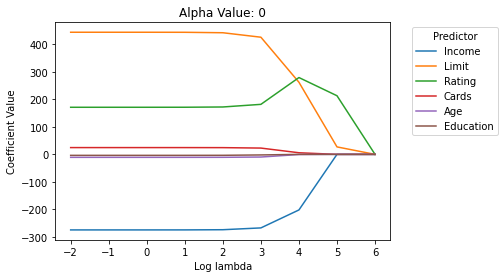

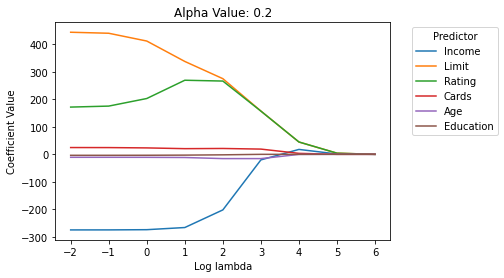

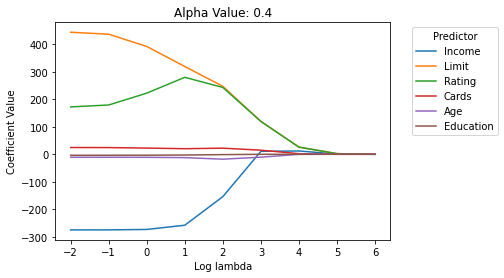

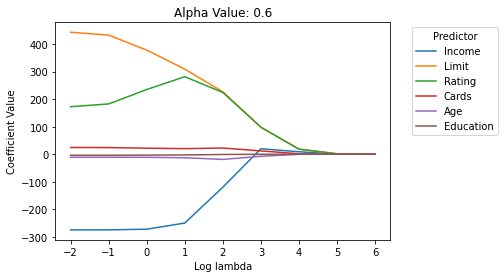

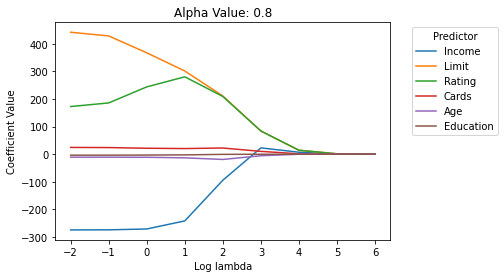

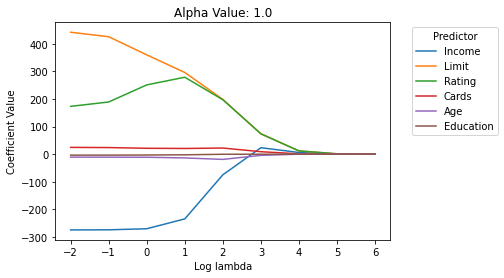

In [22]:
# observe the coefficient values as a function of lambda for each alpha
# plotting mean coefficient vectors over the 5 folds
mean_betas = np.mean(elastic_net.B_trained, 0)
pred_names = df.columns

for i_alpha, alpha in enumerate(elastic_net.alphas):
    for i_beta in range(mean_betas.shape[1]):
        plt.plot(
            np.log10(elastic_net.lambdas), 
            mean_betas[:, i_alpha, i_beta],  
            label = pred_names[i_beta]
        )
    plt.legend(bbox_to_anchor = (1.05, 1), loc = 'upper left', title = 'Predictor')
    plt.xlabel('Log lambda')
    plt.ylabel('Coefficient Value')
    plt.title('Alpha Value: {}'.format(alpha))
    plt.show()
    plt.close()

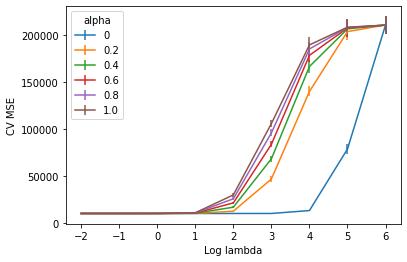

In [23]:
# observe the CV MSE over values of lambda and alpha
for i_alpha, alpha in enumerate(elastic_net.alphas):
    se = np.std(elastic_net.cv_vals[..., i_alpha], 0) / np.sqrt(elastic_net.nfolds)
    plt.errorbar(
        np.log10(elastic_net.lambdas), 
        np.mean(elastic_net.cv_vals[..., i_alpha], 0), 
        yerr = se,
        label = str(alpha)
    )
    plt.xlabel('Log lambda')
    plt.ylabel('CV MSE')
    
plt.legend(title = 'alpha')
plt.show()

In [24]:
# lambda and alpha with lowest cv mse
print('Best lambda: {}; Best alpha: {}'.format(
    elastic_net.best_lambda, elastic_net.best_alpha)
)

Best lambda: 100.0; Best alpha: 0


In [25]:
# coefficient vector for optimal lambda and alpha
elastic_net.B

array([[-274.05635224],
       [ 445.96623908],
       [ 168.88313848],
       [  24.50380661],
       [ -10.84234129],
       [  -3.36035773],
       [   5.05871903],
       [ 127.8010484 ],
       [  -3.30073476]])

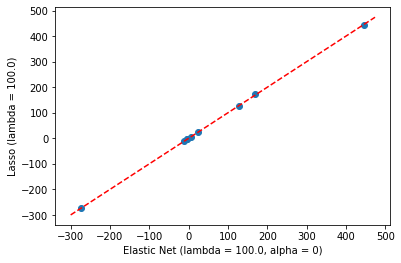

In [26]:
# coefficient vector for optimal lambda given alpha = 0 (lasso)
# coefficicents look relatively similar to elastic net

# get cv mse given alpha = 0
cv_mse_alpha_0 = np.mean(elastic_net.cv_vals[..., 0], 0)

# find index of lambda with lowest cv mse
lambda_ind = np.argmin(cv_mse_alpha_0)
lambda_optimal = elastic_net.lambdas[lambda_ind]

# get the mean coefficient vector under lambda and alpha for all 5 folds
B_mean = np.mean(elastic_net.B_trained[:, lambda_ind, 0, :], 0)

# plot against B with optimal lambda and alpha
plt.scatter(elastic_net.B, B_mean)
plt.plot(np.arange(-300, 475), np.arange(-300, 475), '--', color = 'r')
plt.xlabel('Elastic Net (lambda = {}, alpha = {})'.format(elastic_net.best_lambda, elastic_net.best_alpha))
plt.ylabel('Lasso (lambda = {})'.format(lambda_optimal))
plt.show()

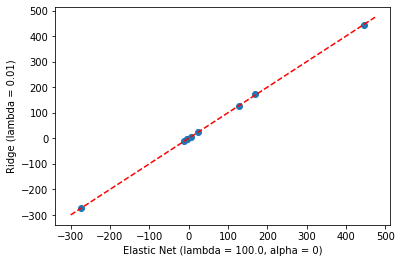

In [27]:
# coefficient vector for optimal lambda given alpha = 1 (ridge)
# coefficients look similar to elastic net and lasso
# because best alpha was in the middle

# get cv mse given alpha = 1
cv_mse_alpha_1 = np.mean(elastic_net.cv_vals[..., -1], 0)

# find index of lambda with lowest cv mse
lambda_ind = np.argmin(cv_mse_alpha_1)
lambda_optimal = elastic_net.lambdas[lambda_ind]

# get the mean coefficient vector under lambda and alpha for all 5 folds
B_mean = np.mean(elastic_net.B_trained[:, lambda_ind, -1, :], 0)

# plot against B with optimal lambda and alpha
plt.scatter(elastic_net.B, B_mean)
plt.plot(np.arange(-300, 475), np.arange(-300, 475), '--', color = 'r')
plt.xlabel('Elastic Net (lambda = {}, alpha = {})'.format(elastic_net.best_lambda, elastic_net.best_alpha))
plt.ylabel('Ridge (lambda = {})'.format(lambda_optimal))
plt.show()

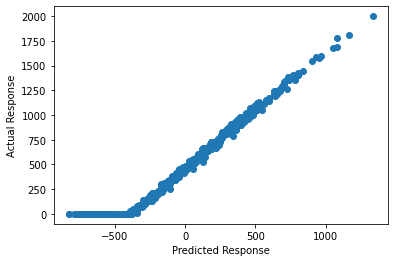

In [28]:
# predict responses and compare against actual responses
y_hat = elastic_net.predict(elastic_net.x)
plt.scatter(y_hat, elastic_net.y)
plt.xlabel('Predicted Response')
plt.ylabel('Actual Response')
plt.show()